<h1 style="red"> Derma TN <h1>

<h1>Importation</h1>

In [1]:

import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

<h5>variables paths</h5>

In [2]:
# Paths
IMG_SAVE_PATH = 'data/train'
IMG_SAVE_PATH_TESTING = 'data/val'
# Mapping from string to integer labels
Str_to_Int = {
    'Actinic keratosis': 0,
    'Basal cell carcinoma': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma': 5,
    'Squamous cell carcinoma': 6,
    'Vascular lesion': 7
}
NUM_CLASSES = len(Str_to_Int)

# Function to map string labels to integers
def str_to_Int_mapper(val):
    return Str_to_Int[val]

<h1>Data Preparation</h1>

In [3]:
# Data Preparation
def load_data(path):
    dataset = []
    for directory in os.listdir(path):
        directory_path = os.path.join(path, directory)
        for image_file in os.listdir(directory_path):
            image_path = os.path.join(directory_path, image_file)
            try:
                img = tf.keras.preprocessing.image.load_img(image_path, target_size=(240, 240))
                img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                dataset.append([img_array, directory])
            except FileNotFoundError:
                print(f'Image file not found: {image_path}. Skipping...')
    return zip(*dataset)

<h1>Data loading for training<h1>

In [4]:
# Load training data
data, labels = load_data(IMG_SAVE_PATH)
labels = np.array([str_to_Int_mapper(label) for label in labels])
data = np.array(data)
labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)

<h1>Data loading for testing

In [5]:
# Load testing data
testing_data, testing_labels = load_data(IMG_SAVE_PATH_TESTING)
testing_labels = np.array([str_to_Int_mapper(label) for label in testing_labels])
testing_data = np.array(testing_data)
testing_labels = tf.keras.utils.to_categorical(testing_labels, num_classes=NUM_CLASSES)

<h1>Data augemntation</h1>

In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(data, labels, batch_size=32)

<h1> Transfer learning </h1>

In [7]:
# Create Transfer Learning Model
def create_transfer_learning_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Unfreeze some layers of the base model for fine-tuning
    for layer in base_model.layers:
        layer.trainable = True
    
    return model

model = create_transfer_learning_model()

<h1> Summary of model </h1>

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 60, 60,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 60, 60,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 60, 60,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 60, 60,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 60, 60,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 60, 60,    │     12,288 │ conv2_block2_0_r

 Total params: 8,095,304 (30.88 MB)

 Trainable params: 8,011,656 (30.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

<h1>Callbacks</h1>

In [9]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
]

<h1>Compile model</h1>

In [10]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


<h1> Train the model </h1>

In [11]:
# Train Model
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(data) // 32,
    validation_data=(testing_data, testing_labels),
    callbacks=callbacks
)

Epoch 1/30


C:\Users\moham\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 474s 8s/step - accuracy: 0.2337 - loss: 2.1932 - val_accuracy: 0.3529 - val_loss: 1.7725 - learning_rate: 1.0000e-04
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 6:56 7s/step - accuracy: 0.5312 - loss: 1.2335

C:\Users\moham\miniconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 374ms/step - accuracy: 0.5312 - loss: 1.2335 - val_accuracy: 0.3442 - val_loss: 1.7738 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 453s 8s/step - accuracy: 0.5700 - loss: 1.1512 - val_accuracy: 0.3943 - val_loss: 1.6157 - learning_rate: 1.0000e-04
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 376ms/step - accuracy: 0.5938 - loss: 1.1715 - val_accuracy: 0.3900 - val_loss: 1.6229 - learning_rate: 1.0000e-04
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 451s 8s/step - accuracy: 0.6925 - loss: 0.8605 - val_accuracy: 0.4946 - val_loss: 1.4866 - learning_rate: 1.0000e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 376ms/step - accuracy: 0.8125 - loss: 0.7237 - val_accuracy: 0.4989 - val_loss: 1.4538 - learning_rate: 1.0000e-04
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 450s 8s/step - accuracy: 0.7485 - loss: 0.6893 - val_accuracy: 0.5795 - val_loss: 1.3708 - learning_rate: 1.0000e-04
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 374ms/step - accuracy: 0.8125 - l

<h1> Plot training history</h1>

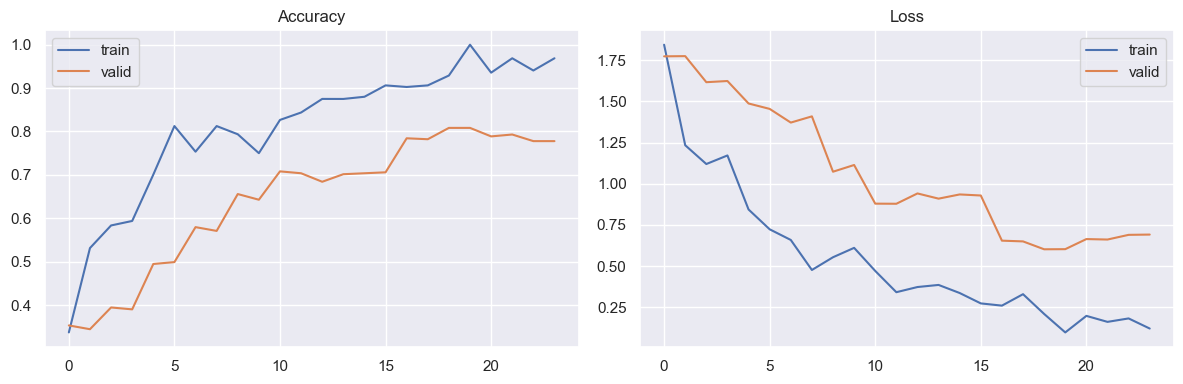

In [12]:
# Plot Training History
def plot_acc(history):
    sns.set()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=axes[0])
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=axes[0])
    axes[0].set_title('Accuracy')
    
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=axes[1])
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=axes[1])
    axes[1].set_title('Loss')
    
    plt.tight_layout()
    plt.show()

plot_acc(history)

<h1> Save the model for furthr use </h1>

In [18]:
# Save the Model
model.save("mobile_net.h5")

<h1> Evalue the model </h1>

In [14]:
# Evaluate Model
test_predictions = model.predict(testing_data)
y_true = np.argmax(testing_labels, axis=1)
y_pred = np.argmax(test_predictions, axis=1)
# Print classification report
print(classification_report(y_true, y_pred, target_names=Str_to_Int.keys()))

15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
                         precision    recall  f1-score   support

      Actinic keratosis       0.77      0.64      0.70        56
   Basal cell carcinoma       0.90      0.92      0.91        60
       Benign keratosis       0.73      0.97      0.83        69
         Dermatofibroma       0.76      0.81      0.78        47
      Melanocytic nevus       0.75      0.76      0.75        54
               Melanoma       0.86      0.72      0.79        58
Squamous cell carcinoma       0.80      0.69      0.74        65
        Vascular lesion       0.96      0.94      0.95        50

               accuracy                           0.81       459
              macro avg       0.82      0.81      0.81       459
           weighted avg       0.81      0.81      0.81       459



<h1>Confusion matrix for precision of model for each deseas</h1>

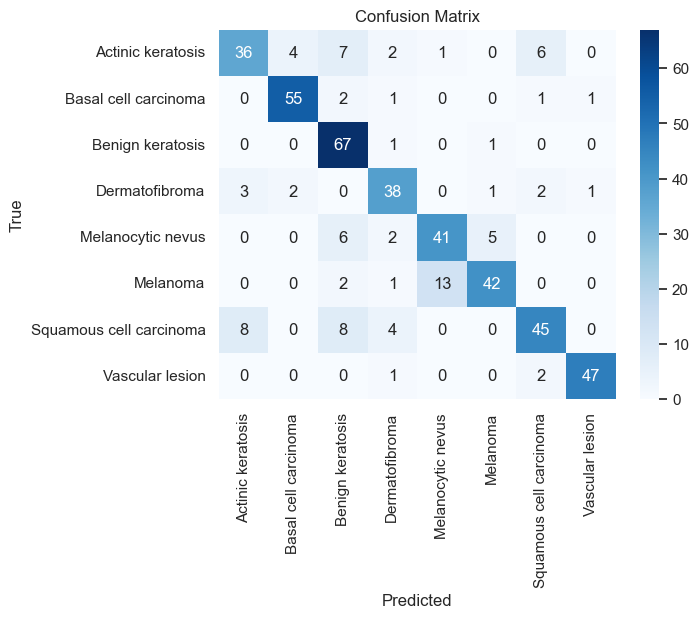

In [15]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Str_to_Int.keys(), yticklabels=Str_to_Int.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<h1> Draw model image for PFE  </h1>

In [16]:
!pip install pydot

In [ ]:
from tensorflow.keras.utils import plot_model

# Load your model (if not already loaded)
# model = create_transfer_learning_model()  # Assuming you've defined your model

# Save the model visualization
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
